# Predicting mRNA Degradation for Vaccine Development
The [Das Lab at Stanford](https://daslab.stanford.edu/) has provided experimental results so that the Kaggle community can help understand what leads to high RNA degradation rates so that stable molecules can be used in vaccines.

## mRNA Vaccines For COVID-19
* Messenger RNA (mRNA) vaccines are a promising new candidate for the COVID-19 vaccine because they can be developed much faster than conventional methods and can elicit strong immunity. 
* They use short segments of mRNA that encode for viral proteins, including the spike proteins essential for viral entry into human cells. 
* A major challenge to their widespread deployment is their short shelf-life, typically requiring storage at -80C temperatures. 
* Single-stranded mRNA are short-lived and the factors leading to spontaneously degrading remains poorly understood.
* Machine learning applied to results from high throughput experiments can help scientists predict degradation rates and quickly develop more stable mRNA molecules.  

## Dataset
* 2400 RNA molecules in a training set. Length 107 base pairs.
* 629 RNA molecules in a public test set. Length 107 base pairs
* 3005 RNA molecules in a private test set. Length 140 base pairs.

    ### Inputs   
    * `sequence`: RNA sequence 'AUGCAGUAUC...'
    * `structure`: sequence like '(((...)))...((..(..)).)'
        * '.' unpaired bases
        * '(' and ')' are bases paired with a later or earlier position, respectively
    * `predicted_loop_type`: sequence like 'EEESSISSSBBSHHHSSSXX...'
        ** Estimate of the structural context for the most likely configuration.
        * S: paired "Stem" 
        * M: Multiloop 
        * I: Internal loop 
        * B: Bulge 
        * H: Hairpin loop 
        * E: dangling end
        * X: eXternal loop
    * `bpps`: Base pairing probability matrix
        * matrix of probabilities that position $i$ pairs with position $j$.   
    
    ### Predicted Outputs
    * `reactivity`: array of floats for measure reactivity at each position
    * `deg_Mg_ph10`: similar to `reactivity` when in a magnesium solution at pH 10.
    * `deg_Mg_50C`: similar to `reactivity` when in a magnesium solution at 50C.
    * Only the first 68 positions used for public set and first 91 positions used for private set
    
## Challenges
* mRNA structure connects distant positions in the sequence.
    * The single-stranded mRNA folds up on itself when bases at different, somtimes distant, positions pair up. This forms a series of double-stranded helices and loops. 
        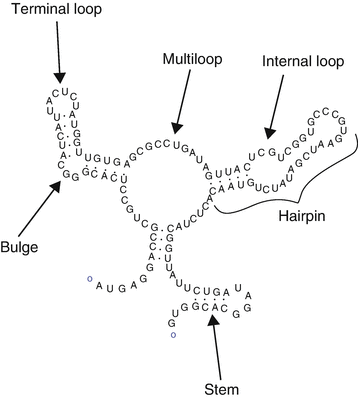
    * Additional interactions between bases can form more complicated 3D structures. 
* A single mRNA sequence can form different structures and fluctuate between them, depending on temperature and other conditions.
    * Some structures may be more prone to degradation than others. 
* Different sequence lengths used for training vs test sets and for input vs predicted sequences.
* Limited training data

## Approach
* **Recurrent Neural Networks** (RNNs) are a natural choice for sequence data and can easily accommodate the differences in sequence lengths for different data sets. 
* The base pairing probability (`bpps`) matrix contains valuable data on alternative RNA structures but is not in a 1D sequence format. We will **extract several features** that are sequences. 
* 

## Imports and Loading Data

In [ ]:
# Imports
import os
import itertools
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# Set seed for reproducibility
SEED = 1
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [ ]:
data_dir = '/kaggle/input/stanford-covid-vaccine/'
train_df = pd.read_json(data_dir + 'train.json', lines = True)
test_df = pd.read_json(data_dir + 'test.json', lines = True)
sample_submission = pd.read_csv(data_dir + 'sample_submission.csv')

In [ ]:
train_df.head()

## Features from Base Pairing Probabilities
The base pairing probability matrix $B(i,j)$ shows that bases at $i$ can pair with bases at multiple other positions, $j$, with varying probabilities. This information can help predict degradation rates but we need to extract 1D features for the RNN. These features should be independent of the length of the sequence, since the public and private test sets have different lenghts. 

### Features
* `bpps_max`: max probability = max of $B(i,j)$ over $j$.
* `bpps_sum`: total probability = sum of $B(i,j)$ over $j$.
* `bpps_ent`: entropy of probability distribution = $\sum_j -B(i,j) \log_2 B(i,j)$
    * This roughly measures how much the distribution is spread out over different positions in a length-independent way.
   
### Length-dependent features (not used)
* mean probability: the additional entries for longer sequences are mostly 0 (i.e. no pairing) so the mean becomes smaller.
* number of nonzero $B(i,j)$: sensitive to even small non-zero probabilities that may appear more often for longer sequences.

In [ ]:
bpps_dir = '../input/stanford-covid-vaccine/bpps/'
files = os.listdir(bpps_dir)
bpps = np.load(bpps_dir + files[10])

plt.matshow(bpps, vmax=1, origin='lower') 
plt.title('Example BPPS Matrix');
plt.gca().xaxis.tick_bottom();

In [ ]:
# Add features to dataframe
ids = []
bpps_max = []
bpps_sum = []
bpps_ent = []
for file in files:
    ids.append(file.split('.')[0])
    bpps = np.load(bpps_dir+file)
    bpps_max.append(np.max(bpps,axis=1))
    bpps_sum.append(np.sum(bpps,axis=1))
    ent = np.zeros(bpps.shape)
    ent[bpps>0] = -bpps[bpps>0]*np.log2(bpps[bpps>0])
    ent_bool = np.any(np.isnan(ent),axis=1)
    if np.any(ent_bool):
        break
    bpps_ent.append(np.sum(ent,axis=1))
    
bpps_df = pd.DataFrame({'id':ids, 'bpps_max':bpps_max, 'bpps_sum':bpps_sum, 'bpps_ent':bpps_ent})

train_df = train_df.join(bpps_df.set_index('id'),on='id',how='left')
test_df = test_df.join(bpps_df.set_index('id'),on='id',how='left')

# Augmentation
Given that the training set has a somehwat small number of examples, increasing its size through augmentation can be useful. The same RNA molecule can have multiple structures, so we can obtain additional data by generating additional structures for each molecule. 

In the [Augmentation Data](https://www.kaggle.com/michaelpearce2/augmentation-data/) notebook, following the approach in [Tito's notebook](https://www.kaggle.com/its7171/how-to-generate-augmentation-data), I generated one additional set of `structure` and `predicted_loop_type` sequences for all RNA molecule `sequence`.  The new sequences were included as additional training examples with the same predicted outputs as the original `sequence`, effectively doubling the training set size. The `structure` sequences were generated using the the [ViennaRNA](https://www.tbi.univie.ac.at/RNA/) package. 

Test Time Augmentation: additional structures were generated for both test sets. When predicting the degradation rates, the average for both structures was used as the final prediction.

### Alternative approaches
* Instead of generating 1 additional sequence for each strain, we could instead have a cutoff on the "score". Some RNA molecules will have many high "score" structures and others will have only one. 
* Using the same degradation rates as the predicted values for multiple structures of the same molecule may not be appropriate. Instead we could add the additional structures as additional input features for each molecule. Each structure could be weighted by some function of its "score".

In [ ]:
AUGMENT = True

In [ ]:
def add_aug_data(df, aug_df):
    target_df = df.copy()
    new_df = aug_df[aug_df['id'].isin(target_df['id'])]
                         
    del target_df['structure']
    del target_df['predicted_loop_type']
    new_df = new_df.merge(target_df, on=['id','sequence'], how='left')

    df['cnt'] = df['id'].map(new_df[['id','cnt']].set_index('id').to_dict()['cnt'])
    df['log_gamma'] = 100
    df['score'] = 1.0
    df = df.append(new_df[df.columns],ignore_index=True)
    return df

In [ ]:
if AUGMENT:
    aug_df = pd.read_csv('../input/augmentation-data/aug_data.csv')
    train_df = add_aug_data(train_df,aug_df)
    test_df = add_aug_data(test_df,aug_df)

# 3-Hot Encoding
We have 3 sets of categorical features: 'AUGC' base pairs, '().' structure tokens, 'BEHIMSX' loop types. So we can encode the input as a 14-dim vector with 3 "hot" positions, one for each categorical feature.  The 3-Hot encoding is appropriate if each categorical feature affects the degradation rate somewhat independently, which seems like a reasonable starting point. We can optionally embed the 3-hot vector in a higher dimensional space using a fully connected layer.

### Alternatives
* We could encode the input in a 84-dim one-hot vector where each position corresponds a combination of the categorical features, e.g. 'A(S'.  This would be appropriate if we expect each combination to behave uniquely. In practice, the choice of encoding did not make much difference. 

In [ ]:
# columns we are predicting
cat_input_cols = ['sequence', 'structure', 'predicted_loop_type']
num_input_cols = ['bpps_max', 'bpps_sum', 'bpps_ent']

def encoding(df):
    encoder = get_encoder()
    cat_inputs = df[cat_input_cols].apply(lambda x: three_hot_encoding_single_row(x,encoder),axis=1)
    cat_inputs = df_to_array(cat_inputs)
    num_inputs = np.transpose(df_to_array(df[num_input_cols]),(0,2,1))
    inputs = np.concatenate((cat_inputs,num_inputs),axis=-1)
    return inputs

def three_hot_encoding_single_row(row,encoder):
    tokens = list(zip(*[row[col] for col in cat_input_cols]))
    inputs_encoded = encoder.fit_transform(tokens).toarray()
    return inputs_encoded

def get_encoder():
    bases = 'AUGC'
    structs = '().'
    loops = 'BEHIMSX'
    encoder = OneHotEncoder(categories=[list(bases),list(structs),list(loops)])
    return encoder

def df_to_array(df):
    return np.array(df.to_numpy().tolist())

# Loss Function and Weighting
The loss function used in the competition is the mean column-wise root-mean-square error (MCRMSE), where the RMS is taken over all positions (p) in all molecules (m), $$RMS  = \sqrt{\frac{1}{M P}\sum^M_m \sum^P_p (\hat{y}_{mp} - y_{mp})^2}$$

Included with the RNA sequence and structure features are measurement error values for and corresponding signal-to-noise ratios (SNRs). The loss function can be weighted towards less noisy measurements by weighting RNA molecules in the training set by their SNR or error values. 

### Weighting options
* 'log': weight = log(SNR + 1)/2. Gives a reasonable range of weight values based on SNR. 
* 'inv_err':  weight = 1/error. Normalizes each prediction error, $\hat{y}-y$, by the measurement error on a per position basis. 

In [ ]:
WEIGHTING = 'log'

In [ ]:
#Define Loss Function
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=(0, 1))
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=-1)

In [ ]:
def get_weights(df, WEIGHTING):
    if WEIGHTING=='log':
        snr = df['signal_to_noise'].values
        weights = np.log(snr+1.1)/2
    elif WEIGHTING=='inv_err':
        err_cols = ['reactivity_error','deg_error_Mg_pH10','deg_error_Mg_50C']
        err_df = df[err_cols]
        errs = np.array(err_df.apply(lambda x: np.mean([x[col] for col in err_cols],axis=0),axis=1).values.tolist())
        weights = 1/errs
        weights = weights/np.median(weights)  #sets typical weight to one
    else:
        weights = np.ones((df.shape[0]))
    return weights

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
weights_log = get_weights(train_df,'log')
plt.hist(weights_log,30,density=True);
plt.title('Log SNR ')
plt.xlabel('Weight')
plt.ylabel('Prob. Density')

plt.subplot(1,2,2)
weights_inv = get_weights(train_df,'inv_err')
plt.hist(weights_inv.flatten(),30,density=True);
plt.title('Inverse measurement error')
plt.xlabel('Weight')
plt.ylabel('Prob. Density');

# Cross Validation Folds
With the small training set, cross validation is needed to get accurate estimates of the loss on a validation set. 

#### SNR Filtering
The test sets only have signal_to_noise ratios (SNRs) that pass the `SNR_filter`, corresponding to SNR > 1. Similarly we only include train set molecules passing the `SNR_filter` in the validation set. 

#### GroupKFold
![](http://)Since some molecules have similar RNA sequences and we have included augmented data with identical RNA sequences, it's possible for information to "leak" from the training set to the validation set, resulting in validation losses that are overfit compared to the test set loss. To prevent this, we clustered the RNA sequences into many groups and used `GroupKFold` from `sklearn` to keep sequences in the same clusters in the same cross validation folds. 

In [ ]:
FOLDS = 4
SNR_THRESHOLD = 0.3

In [ ]:
pred_cols = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C', 'deg_pH10', 'deg_50C']

class Preprocessor():
    def __init__(self,train_df):
        self.train_df = train_df
        
    def get_cv_folds(self):
        inputs, preds, weights = self.get_inputs_predictions_weights()
        pass_index, fail_index = self.define_filter_indexes()
        labels = self.get_cluster_labels()
        
        gkf = GroupKFold(FOLDS)
        cv_folds = []
    
        stratify = self.train_df['signal_to_noise']  #stratify folds 
        for train_idx, val_idx in gkf.split(inputs[pass_index], stratify[pass_index], labels[pass_index]):
            x_train = np.concatenate((inputs[pass_index][train_idx],inputs[fail_index]))
            y_train = np.concatenate((preds[pass_index][train_idx],preds[fail_index]))
            x_val = inputs[pass_index][val_idx]
            y_val = preds[pass_index][val_idx]
            w_train = np.concatenate((weights[pass_index][train_idx],weights[fail_index]))
            cv_folds.append((x_train,y_train,x_val,y_val,w_train))
        return cv_folds
        
    def get_inputs_predictions_weights(self):
        inputs = encoding(self.train_df)
        preds = np.transpose(df_to_array(self.train_df[pred_cols]),(0,2,1))
        weights = get_weights(self.train_df,WEIGHTING)
        return inputs, preds, weights
    
    def define_filter_indexes(self):
        pass_index = self.train_df['SN_filter']==1
        fail_index = np.logical_and(np.logical_not(pass_index), self.train_df['signal_to_noise']>SNR_THRESHOLD)
        return pass_index, fail_index
    
    def get_cluster_labels(self,n_clusters = 200):
        base2int = {'A':0, 'U':1, 'G':2, 'C':3}
        seq = self.train_df['sequence'].apply(lambda seq: [base2int[x] for x in seq])
        seq = np.array(seq.to_list())
        kmeans_model = KMeans(n_clusters=n_clusters, random_state=SEED).fit(seq)
        labels = kmeans_model.labels_
        return labels



In [ ]:
cv_folds = Preprocessor(train_df).get_cv_folds()

In [ ]:
(x_train,y_train,x_val,y_val,w_train) = cv_folds[0]
print([x_train.shape, y_train.shape, x_val.shape, y_val.shape,w_train.shape])

# Model

The RNN architecture we use is fairly simple.  It's a stack of several Bidirectional GRU layers, with a final Dense layer to output the predictions. The 3-hot vector input for categorical features is embedded in a higher dim space before feeding into the GRU layers. This RNN architecture achieves good performance (MCRMSE 0.262) on the public test set when outputs are ensemble averaged over the cross validation folds. 

GRUs have fewer parameters than LSTMs and may be better suited for smaller data sets like ours. But LSTMs have been shown to be more expressive. We could also consider models with LSTM layers or a mix of LSTM and GRU and even ensemble this collection of models. 

#### Possible Additions
* An initial convolution layer could help parse the local context of each position and would help with interpretability. Would need the convolution layer to output the same length sequence. 
* Adding an attention mechanism could help identify the locations that are important for determining the degradation rates at a particular location. The success of attention mechanisms in Transformer and BERT architectures on NLP tasks suggests that it may capture the secondary structure of RNA molecules, although data is limited in our case. 

In [ ]:
def gru_layer(hidden_dim, dropout):
    gru = layers.GRU(hidden_dim, dropout = dropout,return_sequences=True)
    return layers.Bidirectional(gru)

def build_model(seq_len=107, pred_len=68, 
                dropout=0.5, sp_dropout=0.3, 
                embed_dim=300, gru_dims = [128, 256, 64],
                learning_rate = 0.001):
    
    encode_dim = 14
    num_feature_dim = 3
    inputs = layers.Input(shape=(seq_len, encode_dim + num_feature_dim))
    
    if embed_dim > 0:
        #Embed categorical features using Dense layer.
        categorical_fea = inputs[:, :, :encode_dim]
        numerical_fea = inputs[:, :, encode_dim:]
        embed = layers.Dense(embed_dim,kernel_initializer="uniform",use_bias=False)(categorical_fea)
        hidden = layers.concatenate([embed, numerical_fea], axis=2)
    else:
        hidden = inputs
    
    for dim in gru_dims:
        hidden = gru_layer(dim, dropout)(hidden)
    out = layers.Dense(5, activation='linear')(hidden)
    
    # Truncate output to the prediction length
    out_truncated = out[:, :pred_len]
    
    model = keras.Model(inputs=inputs, outputs=out_truncated)
    model.compile(tf.optimizers.Adam(learning_rate = learning_rate), loss=MCRMSE)
    
    return model

In [ ]:
model = build_model(seq_len = x_train.shape[1])
model.summary()

In [ ]:
histories = []
models = []

for ii, (x_train,y_train,x_val,y_val,w_train) in enumerate(cv_folds):
    model = build_model(seq_len = x_train.shape[1])
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
        batch_size=64, 
        epochs=75, 
        verbose=2, 
        sample_weight=w_train,
        callbacks=[keras.callbacks.ReduceLROnPlateau(patience = 10, factor=0.3),
                   keras.callbacks.ModelCheckpoint(f'model_{ii}.h5',save_weights_only = True,save_best_only=True)
    #                keras.callbacks.EarlyStopping(patience=15,restore_best_weights = True)
                  ])

    models.append(model)
    histories.append(history)


In [ ]:
for ii, history in enumerate(histories):
    loss =  history.history['loss']
    val_loss = history.history['val_loss']
    if ii==0:
        plt.plot(loss, color='C0', label='Loss')
        plt.plot(val_loss, color='C1', label='Val. Loss')
    else:
        plt.plot(loss, color='C0')
        plt.plot(val_loss, color='C1')
plt.xlabel('Epoch')
plt.ylabel('MCRMSE')
plt.title('Training History')

# Competition Predictions
The predicted output for the test sets averages over the ensemble of all trained models. The outputs are also averaged over the additional data from augmentation when RNA molecules have the same `id`. 


In [ ]:
public_df = test_df.query("seq_length == 107")
private_df = test_df.query("seq_length == 130")

public_inputs = encoding(public_df)
private_inputs = encoding(private_df)

In [ ]:
for ii in range(FOLDS):
    
    model_public = build_model(seq_len=107, pred_len=107)
    model_private = build_model(seq_len=130, pred_len=130)

    model_public.load_weights(f'model_{ii}.h5')
    model_private.load_weights(f'model_{ii}.h5')
    
    if ii == 0:
        public_preds = model_public.predict(public_inputs)/FOLDS
        private_preds = model_private.predict(private_inputs)/FOLDS
    else:
        public_preds += model_public.predict(public_inputs)/FOLDS
        private_preds += model_private.predict(private_inputs)/FOLDS
    

In [ ]:
preds_ls = []

for df, preds in [(public_df, public_preds), (private_df, private_preds)]:
    for i, uid in enumerate(df.id.unique()):
        single_pred = np.mean(preds[df['id']==uid],axis=0)
        single_df = pd.DataFrame(single_pred, columns=pred_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]
        
        target_cols = ['id_seqpos', 'reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
        preds_ls.append(single_df[target_cols])

preds_df = pd.concat(preds_ls)
preds_df.head()

In [ ]:
submission = sample_submission[['id_seqpos']].merge(preds_df, on=['id_seqpos'])
submission.to_csv('submission.csv', index=False)